# INFO-H-515 -  Big Data : Distributed Data Management and Scalable Analytics

### Geisser Niklaus -  [niklaus.geisser@ulb.be](mailto:niklaus.geisser@ulb.be) - Student ID 469478
### Gerard Joan -       [joan.sebastian.gerard.salinas@ulb.be](mailto:joan.sebastian.gerard.salinas@ulb.be) - Student ID 471612

# Time Series Prediction with Linear Models


# Introduction

The main goal of this project was to apply the knowledge acquired during the course by designing and implementing an online forecasting system. In order to achieve this purpose, Kafka was used as the distributed streaming platform whereas spark handled all the corresponding data processing to make predictions in a distributed way.

## General imports

In [1]:
import time
import re, ast
import numpy as np
import os
import glob
import json
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn import linear_model
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from message import Message
from rls import RLS

### Start Spark session


In [2]:
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils


os.environ['PYSPARK_SUBMIT_ARGS'] = '--conf spark.ui.port=4050 '+\
                        '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.4.4 '+\
        '--conf spark.driver.memory=2g  pyspark-shell'

executors = 2

spark = SparkSession \
    .builder \
    .master("local[{0}]".format(executors)) \
    .appName("KafkaReceive") \
    .getOrCreate()

### Function to connect Spark Streaming and Kafka on a given topic

In [3]:
#This function creates a connection to a Kafka stream
#You may change the topic, or batch interval
#The Zookeeper server is assumed to be running at 127.0.0.1:2181
#The function returns the Spark context, Spark streaming context, and DStream object
def getKafkaDStream(spark,topic='persistence',batch_interval=10):

    #Get Spark context
    sc=spark.sparkContext

    #Create streaming context, with required batch interval
    ssc = StreamingContext(sc, batch_interval)

    #Checkpointing needed for stateful transforms
    ssc.checkpoint("checkpoint")
    
    #Create a DStream that represents streaming data from Kafka, for the required topic 
    dstream = KafkaUtils.createStream(ssc, "127.0.0.1:2181", "spark-streaming-consumer", {topic: 1})
    
    return [sc,ssc,dstream]


In [4]:
def parse_message(x):
    """
    This message transforms the received json string into a message object.
    
    :param x string containing the message
    
    :return Message
    """
    messageDict = x[1]
    messageDict = json.loads(messageDict)
    message = Message()
    message.id = messageDict["id"]
    message.x = messageDict["x"]
    return message
    

In [33]:
def get_data_from_file(executors, prefix='test', search_dir = "./", file_index=-1):
    """
    In charge of reading the last file containing information regarding the last stream
    and processing it to return an tuple with the keys, mses and the stream data.
    
    :param executors If the algorithm uses 2 executors then this will create two partitions [0,1] if it is 4 it will be [0,1,2,3]
    :param prefix     It is the prefix of the directory name
    :param search_dir Where it should the algorithm look for these files
    :param file_index If it is -1 it will use the last file (containing the last stream data), if it is 0 it will
                      use the first file (containing the first stream data)
                      
    :return (keys_all, mses_all, ys_all)     keys, mses and data stream
    """
    keys_all = []
    mses_all = []
    ys_all = []
    y_hat_all = []
    idx = -1
    
    count = 0
    
    files = list(filter(os.path.isdir, glob.glob(search_dir + prefix +"*")))
    files.sort(key=lambda x: os.path.getmtime(x))

    for j in range(executors):
        file_name = "/part-0000%s" % str(j)
        data=files[file_index] + file_name
        F=open(data, "r")
        models = F.read().split('\n')

        for model in models:
            if (len(model) > 0):
                count += 1
                rls1 = model.split(' separator ')
                key = rls1[0]
                mses = list(map(lambda x: float(x), rls1[1][1:-1].split(',')))
                ys = list(map(lambda x: float(x), rls1[2][1:-1].split(',')))
                y_hat = list(map(lambda x: float(x), rls1[3][1:-1].split(',')))
                idx = int(rls1[4])
                keys_all.append(key)
                mses_all.append(mses)
                ys_all = ys
                y_hat_all.append(y_hat)
                
    return (keys_all, mses_all, ys_all, y_hat_all, idx)

In [6]:
def plot_mse(range_view_start, range_view_end, keys, mses):
    """
    It plots the mse for a given range. If the stream size is 1000 then the max value for range_view_end is 1000.
    
    :param range_view_start Start of the range
    :param range_view_end   End of the range
    :param keys             The name of the models
    :param mses             The mses values
    
    """
    x = np.arange(range_view_start, range_view_end)
    for i in range(len(keys)):
        plt.plot(x, mses[i][range_view_start: range_view_end], label=keys[i])

    plt.title('MSE')
    plt.legend(loc="upper left")
    plt.xlabel('time')
    plt.ylabel('mse')
    plt.show()

In [7]:
def plot_time_series(range_view_start, range_view_end, ys):
    """
    It plots the time series for a given range. If the stream size is 1000 then the max value for range_view_end is 1000.
    
    :param range_view_start Start of the range
    :param range_view_end   End of the range
    :param keys             The name of the models
    :param mses             The mses values
    
    """
    x = np.arange(range_view_start, range_view_end)
    plt.plot(x, ys[range_view_start:range_view_end])
    plt.title('Time Series')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.show()

In [8]:
def plot_time_series_prediction(range_view_start, range_view_end, keys, ys, y_hat):
    """
    It plots the time series for a given range. If the stream size is 1000 then the max value for range_view_end is 1000.
    
    :param range_view_start Start of the range
    :param range_view_end   End of the range
    :param keys             The name of the models
    :param mses             The mses values
    :param ys               time series values
    :y_hat                  predictions
    
    """
    
    # Adding subplots dynamically based on the number of models

    tot = len(keys)
    cols = 2
    
    rows = tot // cols 
    rows += tot % cols
    position = range(1,tot + 1)
    
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
    fig = plt.figure(1)
    fig.suptitle('Time Series vs Prediction', fontsize=15)

    for k in range(tot):

        # add every single subplot to the figure with a for loop
        fig.set_figheight(6) 
        fig.set_figwidth(16)
        
        ax = fig.add_subplot(rows,cols,position[k])
        x = np.arange(range_view_start, range_view_end)
        ax.plot(x, ys[range_view_start: range_view_end], label="Time series")
        ax.plot(x, y_hat[k][range_view_start: range_view_end], label="Prediction")
        
        ax.legend(loc="upper right")
        ax.set_title(keys[k])
        ax.set_xlabel("time")
        ax.set_ylabel("values")
          
    

# Persistence model

In this section, a basic persistence model will be implemented where the prediction of a future timestep will depend on the average values of previous timesteps. A "naive" approach will be to make a prediction based on the previous timestep which will be equivalent to the "average" of the last value. In order to have a more detail comparsion, several approaches will be tested for doing the average of the last "V" values.

In [22]:
def persistence_prediction(stream, tail):
    """
    Computes the prediction of future time-steps based on a stream and last "V" values.
    
    :param stream  list of elements received by kafka
    :param tail    last "V" values of a previous stream
    
    :return:       predictions
    """
    predictions = []
    len_tail = len(tail)  # Length of V
    last_values_plus_stream = np.concatenate((tail, np.array(stream))) # Array that contains the "V" last elements of the stream
    
    for time_in_stream in range(len(stream)):
        time_in_concat = time_in_stream + len_tail
        sliding_window = last_values_plus_stream[time_in_stream:time_in_concat]
        prediction = np.mean(sliding_window)
        predictions.append(prediction)
        
    return predictions

In [28]:
def update_function_persistence(new_values, state):
    """
    Updates the state for the persistence models.
    
    :param new_value  stream to be processed
    :param state      current state in memory
    
    :return:          new state
    """
    L = len(new_values)
    
    if L > 0:
        key, predictions, tail, mse, mses, D, N, idx = state  # Unpacking the state
        
        result_predictions = []
        mses = []
        D = []

        for message in new_values:
            stream = message.x
            idx = message.id
            predictions = persistence_prediction(stream, tail)
            if N == 0:  # Replace the "v" first values of the predictions with the "v" first values of the stream if first time
                predictions[:len(tail)] = stream[:len(tail)]
            tail = stream[-len(tail):]  # Update last V values of stream
            err = np.subtract(stream, predictions)  ## prediction error for the latest values
            N += len(stream)
            for e in err:
                mse = mse + 1.0 / N * (pow(e, 2.0) - mse)  ## sequential update of MSE
                mses.append(mse)
            result_predictions = result_predictions + predictions
            D = D + stream
            
        return key, result_predictions, tail, mse, mses, D, N, idx
    else:
        return state

In [29]:
def get_initial_state_persistence(v, sc):
    """
    Gets the initial state for persistence models.
        ex: v = [1,2,3, 4]
            return RDD with values [('V1', state_V1),('V2', state_V2),('V3', state_V3),('V4', state_V4)]
    
    :param v:  Numbers array of last values required to average
    
    :return:   [(key, state)] RDDS
    """
    rdds = []
    for value in v:
        key = 'V%s' % str(value)
        tail = np.zeros(value)  # V last elements from previous stream (initially set to 0)
        mse = 0  # mean square error
        mses = [] # history of mse
        D = [] # processed stream
        predictions = []  # Empty array that will store the predicted values for the received stream (Just for visual purposes)
        N = 0  #
        state = (key, predictions, tail, mse, mses, D, N, 0)
        rdd = (key, state)
        rdds.append(rdd)
    return sc.parallelize(rdds)


In [41]:
V = [1,2,3,4] # Averaging the last 1, 2, 3 and 4 values of stream. 

[sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='timeSerieS',batch_interval=2)
initial_state_RDD_persistance = get_initial_state_persistence(V, sc)
data_stream = dstream.map(parse_message)

data_stream = data_stream.flatMap(lambda message: [('V%s' % str(v), message) for v in V])
updated_stream=data_stream.updateStateByKey(update_function_persistence,initialRDD=initial_state_RDD_persistance)
# key separator mses separator stream separator predictions
output_stream = updated_stream.map(lambda x: "%s separator %s separator %s separator %s separator %s" % (str(x[1][0]), str(x[1][4]), str(x[1][5]),str(x[1][1]), str(x[1][7]))).saveAsTextFiles('test-persistence')
# updated_stream.map(lambda x: "%s separator %s separator %s separator %s separator %s" % (str(x[1][0]), str(x[1][4]), str(x[1][5]),str(x[1][1]), str(x[1][7]))).pprint()



In [42]:
ssc.start()

In [43]:
ssc.stop(stopSparkContext=False,stopGraceFully=False)

## Visualize MSE and Time Series

In [44]:
(keys, mses, ys, y_hat, idx) = get_data_from_file(executors, prefix='test-persistence')

Data analisis with data stream # 9


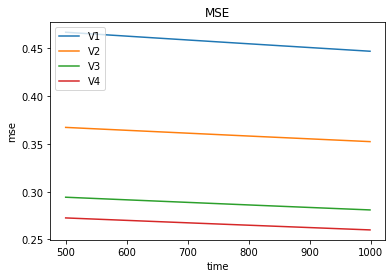

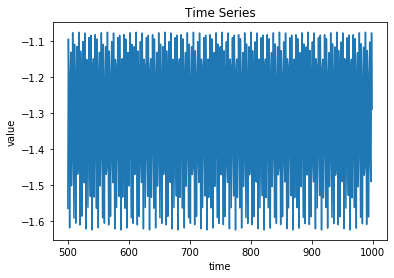

In [45]:
range_view_start = 500
range_view_end = 1000
print('Data analisis with data stream #', idx)
plot_mse(range_view_start, range_view_end, keys, mses)
plot_time_series(range_view_start, range_view_end, ys)

## Visualize Time Series with predictions

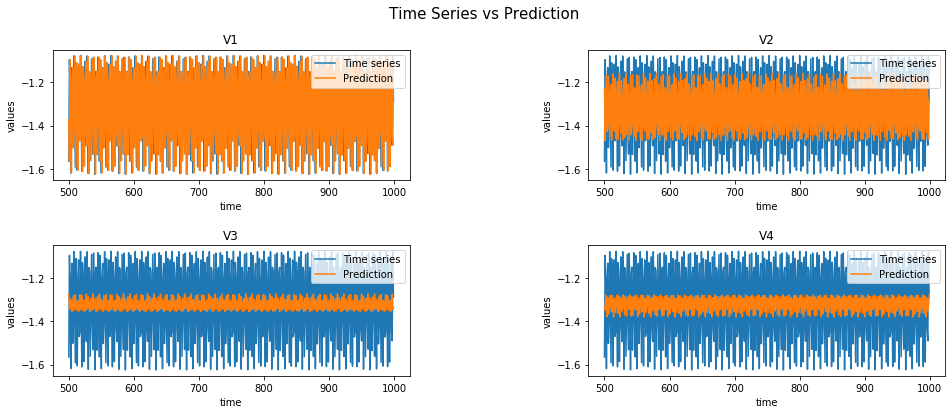

In [46]:
plot_time_series_prediction(range_view_start, range_view_end, keys, ys, y_hat)

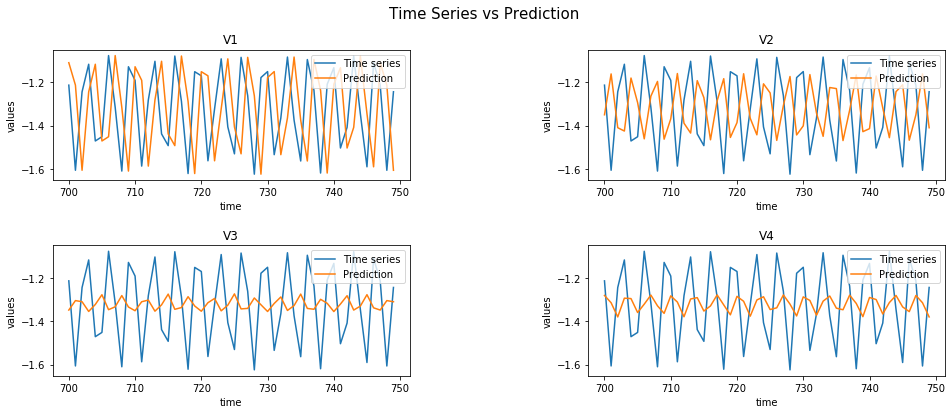

In [47]:
plot_time_series_prediction(700, 750, keys, ys, y_hat)

It can be seen from the results obtained that averaging the last 4 values gives a lower mean-square-error, this makes sense since there is much more information about past time-steps. It can also be seen that the noise in the data makes a big impact in the models.

# Parallel linear models

In this section, the predictions will be made by implementing the Recursive Least Squares (RLS) strategie with different number of parameters (n = {1,2,3,4})

In [48]:
def build_data_set(message, n):
    """
    For message.x = [3,4,5,6,7] and n = 2 this function constructs:
    
    xy = [
        [1, 3, 4, 5], # x1=1, x2=3, x3=4, y=5
        [1, 4, 5, 6], # x1=1, x2=4, x3=5, y=6
        [1, 5, 6, 7], # x1=1, x2=5, x3=6, y=7
    ]
    
    :param message Object Message containing data stream
    :param n       Int containing the number of features 
    
    :return (id, XY_dataset)
    """
    
    ones = [1] * (len(message.x) - n)
    xy = [ones]
    size = len(message.x)
    
    for i in range(n+1):
        xy.append(message.x[i: size + i - n])
    
    xy = np.transpose(xy)
    return (message.id, xy)

In [49]:
def rls_step(y, x, beta, V, nu):
    """
    Recalculates the values for RLS
    
    :param y     Float target value
    :param x     Array of features values
    :param beta  Array of beta values
    :param V     Covariance
    :param nu.   Forgetting Factor
    
    :return (beta, V, err, yhat) updated
    """
    x = np.array(x)
    y = np.array(y)
    V = np.array(V)
    beta = np.array(beta)

    x.shape = (1, len(x))
    beta.shape = (1, x.shape[1])

    V = 1.0/nu * (V - V.dot(x.T).dot(x).dot(V) / (1.0 + float(x.dot(V).dot(x.T))))
    alpha = V.dot(x.T)
    yhat = x.dot(beta.T)
    err = y - yhat
    beta = beta + alpha.T * err

    return (beta, V, err, yhat)

In [50]:
def get_initial_state_linear_models(n, sc):
    """
    Gets the initial state for persistence models.
        ex: n = [1,2,3, 4]
            return RDD with values [('rls1', state1),('rls2', state2),('rls3', state3),('rls4', state4)]
    
    :param n  Array containing the number of features
    
    :return:  [(key, state)] RDDS
    """
    rdds = []
    for i in n:
        key = 'rls%s' % i
        num_features = i + 1
        beta1=np.zeros(num_features)
        tail = np.zeros(num_features)
        v0=10 ## initialization covariance
        V1=np.diag(np.zeros(num_features)+v0) ## initial covariance matrix for model 1
        nu1=1.0 # forgetting factor for model 1

        recentSize=10
        D=[]
        mses=[]
        predictions= []
        mse=0
        N=0
        state = (key, beta1, V1, nu1, mse, mses, N, D, predictions, tail, i, 0)
        rdd = (key, state)
        rdds.append(rdd)

    return sc.parallelize(rdds)

In [51]:
def update_function_linear_models(new_values, state):
    """
    Updates the state for the linear models.
    
    :param new_value  stream to be processed
    :param state      current state in memory
    
    :return           new state
    """
    L=len(new_values)

    if (L>0):
        # Extract the data from state variable
        (algo_key, beta, V, nu, mse, mses, N, D, predictions, tail, n, idx) = state
        
        # reset previous state
        D = []
        predictions = []
        mses = []

        # Iterate over all the datasets received
        for i in range(len(new_values)):
            message = new_values[i]
            
            # Append analyzed values to D vector
            D = D + message.x
            idx = message.id
            y_h = []
            
            # add the last n elements from the previous stream to the beginning of the current one
            if (N > 0):
                message.x = tail + message.x
            
            # define new tail for the next stream
            tail = message.x[-n:]
            
            # build data set for current stream
            (key, data_set) = build_data_set(message, n)

            # iterate over all the samples
            for sample in data_set:

                y = sample[-1]
                x = sample[:-1]

                # Compute RLS state update
                RL = rls_step(y,x,beta,V,nu)

                # Update the state values
                beta =RL[0]
                V = RL[1]
                err = RL[2]
#                 print("Predictions: ", RL[3])
                y_h.append(RL[3][0][0])
                N = N + 1
                mse = mse+1.0/N * (pow(err, 2.0) - mse)
                mses.append(mse[0][0])
                
            predictions= predictions + y_h
            
        return (algo_key, beta, V, nu, mse, mses, N, D, predictions, tail, n, idx)

    else:
        return state


In [62]:
n = [1,2,3,4]

[sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='timeSerieS',batch_interval=1)
initial_state = get_initial_state_linear_models(n, sc)

dataS = dstream.flatMap(lambda data: [('rls%s'%i, parse_message(data)) for i in n])
updatedS = dataS.updateStateByKey(update_function_linear_models, initialRDD=initial_state)

# key separator mses separator stream separator predictions
outmseS=updatedS.map(lambda x: "%s separator %s separator %s separator %s separator %s" % (str(x[1][0]), str(x[1][5]), str(x[1][7]), str(x[1][8]), str(x[1][11]))).saveAsTextFiles('test-linear-models')


In [63]:
ssc.start()

In [64]:
ssc.stop(stopSparkContext=False,stopGraceFully=False)

In [85]:
(keys, mses, ys, y_hat, idx) = get_data_from_file(executors, prefix='test-linear-models', file_index=-2)

Data analisis with data stream # 9


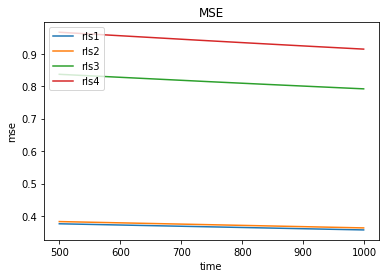

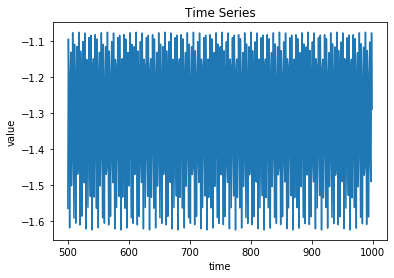

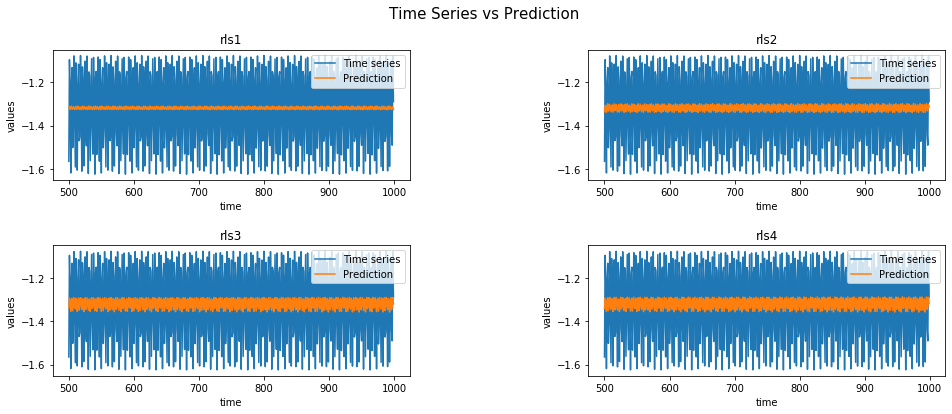

In [86]:
range_view_start = 500
range_view_end = 1000
print('Data analisis with data stream #', idx)
plot_mse(range_view_start, range_view_end, keys, mses)
plot_time_series(range_view_start, range_view_end, ys)
plot_time_series_prediction(range_view_start, range_view_end, keys, ys, y_hat)

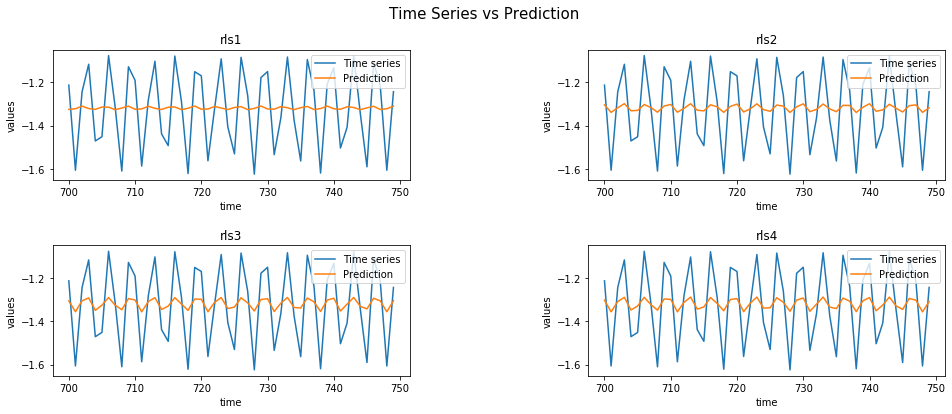

In [70]:
plot_time_series_prediction(700, 750, keys, ys, y_hat)


It can be seen that the mean square error decreases in a considerable way with respect to the persistance model. The model with only one parameter seems to perform better. However, the difference of MSE regarding the other models is not that significant.

## Forgetting factor analysis

In this section, different forgetting factors will be tested in order to see the impact of not taking into acount the whole data in the training phase.

In [71]:
def get_initial_state_forgettin_factor(nus, num_features, sc):
    """
    
    """
    rdds = []
    for nu in nus:
        key = 'nu_%s' % str(nu)
        beta1=np.zeros(num_features)
        tail = np.zeros(num_features)
        v0=10 ## initialization covariance
        V1=np.diag(np.zeros(num_features)+v0) ## initial covariance matrix for model 1
        nu1=nu # forgetting factor

        D=[]
        mses=[]
        predictions= []
        mse=0
        N=0
        state = (key, beta1, V1, nu1, mse, mses, N, D, predictions, tail, num_features-1, 0)
        rdd = (key, state)
        rdds.append(rdd)

    return sc.parallelize(rdds)

In [72]:
nus = [0.99, 0.95, 0.9]

[sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='timeSerieS',batch_interval=1)
initial_state = get_initial_state_forgettin_factor(nus, 2, sc)

dataS = dstream.flatMap(lambda data: [('nu_%s'%str(nu), parse_message(data)) for nu in nus])
updatedS = dataS.updateStateByKey(update_function_linear_models, initialRDD=initial_state)

# key separator mses separator stream separator predictions
outmseS=updatedS.map(lambda x: "%s separator %s separator %s separator %s separator %s" % (str(x[1][0]), str(x[1][5]), str(x[1][7]), str(x[1][8]), str(x[1][11]))).saveAsTextFiles('test-forgetting-factor')


In [73]:
ssc.start()

In [74]:
ssc.stop(stopSparkContext=False,stopGraceFully=False)

In [91]:
(keys, mses, ys, y_hat, idx) = get_data_from_file(executors, prefix='test-forgetting-factor', file_index=-40)

Data analisis with data stream # 9


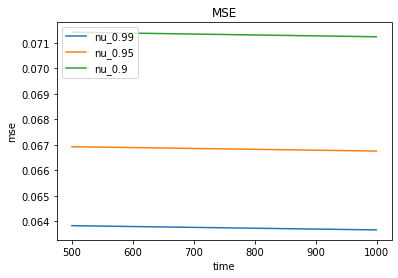

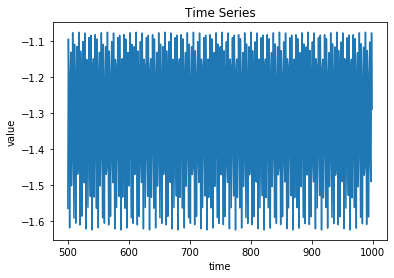

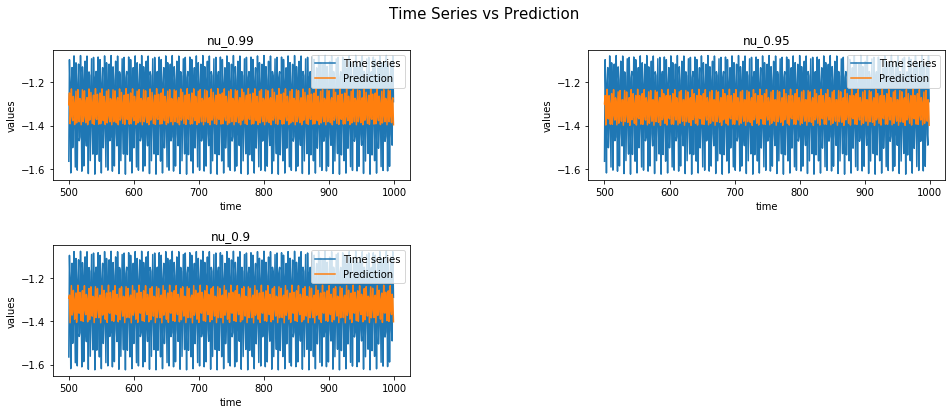

In [92]:
range_view_start = 500
range_view_end = 1000
print('Data analisis with data stream #', idx)
plot_mse(range_view_start, range_view_end, keys, mses)
plot_time_series(range_view_start, range_view_end, ys)
plot_time_series_prediction(range_view_start, range_view_end, keys, ys, y_hat)

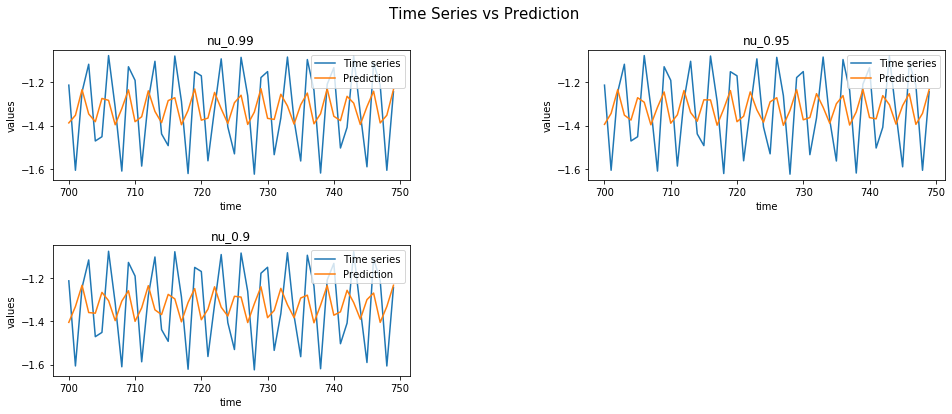

In [93]:
plot_time_series_prediction(700, 750, keys, ys, y_hat)

It can be seen from the results obtained above that the model which results in a smaller MSE uses a forgetting factor of 0.99. Moreover, the MSE increases proportionally on how much the forgetting factor decreases. This is due to the fact that the past values are relevant in the sense that they reduce the impcat of the noise for fitting the model.

## Bonus : Comparing other strategies

In this section, three different strategies will be compared with the best model obtained from the previous steps. The libraries [creme](https://creme-ml.github.io/index.html#) and [scikit_multiflow](https://scikit-multiflow.github.io/) will be used to make the implementation. These are libraries specifically created for online or in<b>creme</b>ntal learning.

### Install creme and scikit multflow

`` pip install creme ``

``pip install -U scikit-multiflow``

### Trouble shooting

Login as root

`` yum install gcc-c++ ``

In [120]:
from creme import linear_model # Linear regression
from creme import neighbors # K-nearest neighbors
from creme import ensemble # For bagging and hedge regressor
from creme import optim

In [121]:
from skmultiflow.trees import RegressionHoeffdingTree
from skmultiflow.meta import AdaptiveRandomForest

In [122]:
def step(key, reg, y, x):
    """
    Performs a learning step

    :param key   Key of the algorithm
    :param reg   Regressor
    :param y     Label
    :param x     Features
    

    :return (error, y_hat)
    """
    x = np.array(x)
    y = np.array(y)
    X = dict(zip(range(len(x[1:])), x[1:])) if "creme" in key else x
    y_hat = reg.predict_one(X) if "skmflow" not in key else reg.predict(np.array([X]))
    reg.fit_one(X, y) if "skmflow" not in key else reg.partial_fit(np.array([X]), np.atleast_1d(y))
    err = y - y_hat

    return np.atleast_1d(err), np.atleast_1d(y_hat)

In [123]:
def get_initial_state_race(models, num_features, sc):
    """
    Gets the initial state for racing models based on a fixed number of parameters
    
    :param models  Array containing the models
    :param n  Array containing the number of features
    :return:  [(key, state)] RDDS
    
    """
    rdds = []
    for model in models:
        key = model[0]
        regr = model[1]
        tail = np.zeros(num_features)
        D = []
        mses = []
        predictions = []
        mse = 0
        N = 0
        state = (key, regr, mse, mses, N, D, predictions, tail, num_features - 1)
        rdd = (key, state)
        rdds.append(rdd)

    return sc.parallelize(rdds)

In [124]:
def update_function_race(new_values, state):
    """
    Updates the state for the different models.

    :param new_value  stream to be processed
    :param state      current state in memory

    :return           new state
    """
    L = len(new_values)

    if L > 0:
        
        # Extract the data from state variable
        (algo_key, regr, mse, mses, N, D, predictions, tail, n) = state

        # reset previous state
        D = []
        predictions = []
        mses = []

        # Iterate over all the datasets received
        for i in range(len(new_values)):
            message = new_values[i]
            
            # Append analyzed values to D vector
            D = D + message.x
            y_h = []

            # add the last n elements from the previous stream to the beginning of the current one
            if (N > 0):
                message.x = tail + message.x

            # define new tail for the next stream
            tail = message.x[-n:]

            # build data set for current stream
            (key, data_set) = build_data_set(message, n)

            # iterate over all the samples
            for sample in data_set:
                y = sample[-1]
                x = sample[:-1]

                # Compute RLS state update
                e, y_hat = step(algo_key, regr, y, x)

                # Update the state values
                err = e
                y_h.append(y_hat[0])
                N = N + 1
                mse = mse + 1.0 / N * (pow(err, 2.0) - mse)
                mses.append(mse[0])

            predictions = predictions + y_h

        return (algo_key, regr, mse, mses, N, D, predictions, tail, n)

    else:
        return state


In [125]:
num_f = 8
nu = 0.99
regr = linear_model.LinearRegression(intercept=110,optimizer=optim.SGD(0.01),intercept_lr=0.3) # Simple linear regression
rls = RLS(num_f, nu) # Best rls model obtained
k_neigh = neighbors.KNeighborsRegressor() # Knn
bagging = ensemble.BaggingRegressor(model=linear_model.LinearRegression(intercept_lr=0.1),n_models=3,seed=42)
hoeffding_tree = RegressionHoeffdingTree()
adaptative_random_forest= AdaptiveRandomForest()

In [126]:
models = [("recursive_ls_best", rls), ("linear_regression", regr), ("k_neighbors", k_neigh),("bagging_regressor",bagging)]
models = [("recursive_ls_best", rls), ("k_neighbors", k_neigh), ("hoeffding_tree",hoeffding_tree)]
models = [("recursive_ls_best", rls), ("creme_kneigh", k_neigh), ("skmflow_hoeffding_tree", hoeffding_tree)]
# models = [("lin", regr), ("kneigh", k_neigh)]
[sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='timeSerieS',batch_interval=1)
initial_state_racing = get_initial_state_race(models, num_f, sc)

dataS = dstream.flatMap(lambda data: [(model[0], parse_message(data)) for model in models])
updatedS = dataS.updateStateByKey(update_function_race, initialRDD=initial_state_racing)

# key separator mses separator stream separator predictions
outmseS=updatedS.map(lambda x: "%s separator %s separator %s separator %s" % (str(x[1][0]), str(x[1][3]), str(x[1][5]), str(x[1][6]))).saveAsTextFiles('test-racing-models')



In [127]:
ssc.start()

In [128]:
ssc.stop(stopSparkContext=False,stopGraceFully=False)

In [129]:
(keys, mses, ys, y_hat) = get_data_from_file(executors, prefix='test-racing-models')

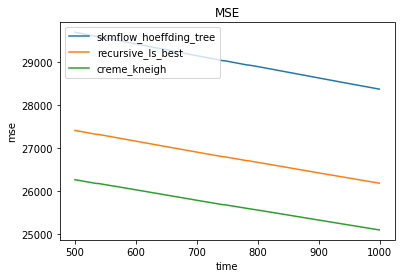

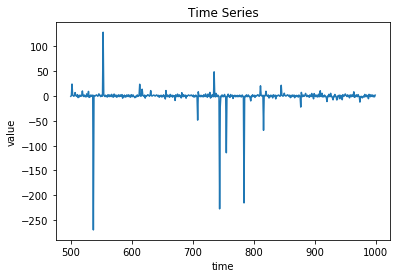

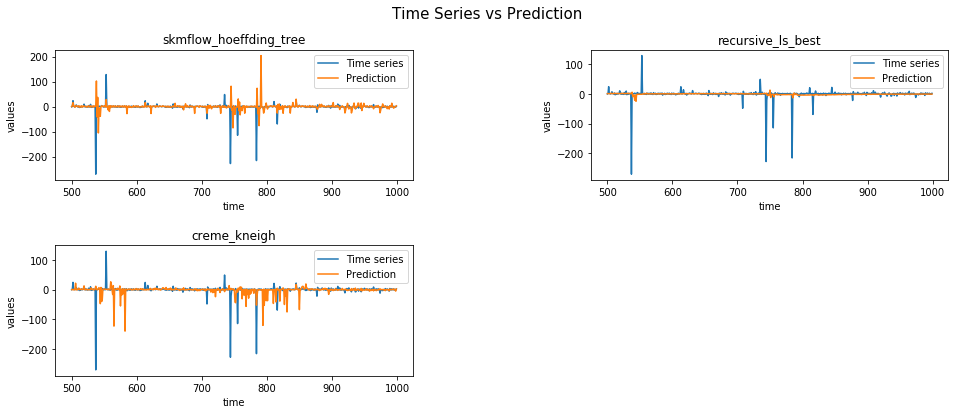

In [136]:
range_view_start = 500
range_view_end = 1000
plot_mse(range_view_start, range_view_end, keys, mses)
plot_time_series(range_view_start, range_view_end, ys)
plot_time_series_prediction(range_view_start, range_view_end, keys, ys, y_hat)

# Results discussion

It can be conclued from the results obtained that the noise in the data can impact in great a great manner the performance of the trained models.




# Conclusions